In [1]:
using Base.Iterators
using Random
using DataFrames
using PyPlot
using StatsBase
using SmoothingSplines
using Graphs
using LaTeXStrings, Latexify

In [2]:
seed = 21;
resdir = "properties_test/stats/";
graphdir = "properties_test/graphs/";

In [3]:
Random.seed!(seed);

In [4]:
#Parameters:

n = 10^4
ξs = range(0.0, 1.0, step = 0.05)
βs = [1.1, 1.5, 1.9]
γs = [2.1, 2.5, 2.9]
min_degs = [5]
is_local = [true, false];

params = sort(reshape(collect(product(n,ξs,βs,γs,min_degs)),:));

Additional functions/data preprocessing:

In [5]:
colnames = [:iter, :modularity, :global_coeff, :avg_local_coeff, Symbol("δ+1"),Symbol("δ+2"),Symbol("δ+3"),
            :giant_component_size, :giant_component_volume, Symbol("size_0.05"), Symbol("size_0.05_relative"),
            Symbol("size_0.1"), Symbol("size_0.1_relative"), Symbol("size_0.15"), Symbol("size_0.15_relative"),
            :internal_edges_mean, :internal_edges_std, :correlation_coeff, :corr_exp];
colnames2 = [:avg, :std, :Q1,:Q2,:Q3, :min, :max];
colnames3 = [:avg_part_coeff, :hubs, :provincial_hubs, :connector_hubs, :kinless_hubs, 
            :ultra_peripheral_nodes, :peripheral_nodes, :connector_nodes, :kinless_nodes];

In [6]:
function get_plot_data(algo, is_local, attr; 
        n = n, ξ = ξ, β = β, γ = γ, min_deg = min_deg,
        resdir = resdir, fname = "stats", colnames= colnames)
    try
        dfname = resdir * "$(algo)_$(fname)_$(n)_$(ξ)_$(β)_$(γ)_$(min_deg)_$(is_local).dat"
        df = DataFrame(Array(hcat([parse.(Float64, x) for x in split.(readlines(dfname),";")]...)'), colnames)
        df[!,attr]
    catch err
        NaN
    end
end 

get_plot_data (generic function with 1 method)

In [7]:
degree_correlation(g) = [sum(sum(degree(g,nei) for nei in neighbors(g,n))/length(neighbors(g,n))
    for n in findall(x-> x == deg,degree(g)))/sum(degree(g).==deg)
        for deg in sort(unique(degree(g))) if deg != 0]

degree_correlation (generic function with 1 method)

In [8]:
function deg_corr_neutral(G, mode::Function)
    x = mode(G)
    return mean(x .^ 2)/mean(x)
end

deg_corr_neutral (generic function with 1 method)

In [9]:
function gen_diff_table(attr; savetable = false,
        params = params, resdir = resdir, fname = "stats", colnames= colnames)
    m = Array{String}(undef, 5, 5)
    m .= " "
    m[1,:] = [" ", "ABCD Global", "ABCD  Local", "LFR  Original", "LFR  NetworKit"]
    m[:,1] = [" ", "ABCD Global", "ABCD  Local", "LFR  Original", "LFR  NetworKit"]
    for (i, (algo_1, islocal_1)) in enumerate([("ABCD", false),("ABCD", true),("LFRog", ""), ("LFR", "")])
        colvals = []
        for (algo_2, islocal_2) in [("ABCD", false),("ABCD", true),("LFRog", ""), ("LFR", "")]
            if algo_1 != algo_2 || islocal_1 != islocal_2
                diffs = [abs(mean(get_plot_data(algo_1, islocal_1, attr; 
                            n = n, ξ = ξ, β = β, γ = γ, min_deg = min_deg,
                            resdir = resdir, fname = fname, colnames= colnames)) 
                            - mean(get_plot_data(algo_2, islocal_2, attr; 
                            n = n, ξ = ξ, β = β, γ = γ, min_deg = min_deg,
                            resdir = resdir, fname = fname, colnames= colnames))) for (n,ξ,β,γ,min_deg) in params]
                diffs = diffs[isnan.(diffs) .== false]
                differences = "$(round(minimum(diffs), digits = 4)) $(round(mean(diffs), 
                                digits = 4)) $(round(maximum(diffs), digits = 4))"
                push!(colvals, differences)
            else
                push!(colvals, " ")
            end
        end
        m[1+i,2:end] = colvals
    end  
    if savetable
        open("$(attr)_diff_table.tex", "w") do file
            write(file, latextabular(m, latex=false))
        end
    end   
    mdtable(m, latex=false) 
end

gen_diff_table (generic function with 1 method)

### Modularity

In [10]:
#Parameters:

ξ = 0.5
β = 1.5
γ = 2.5
min_deg = 5;

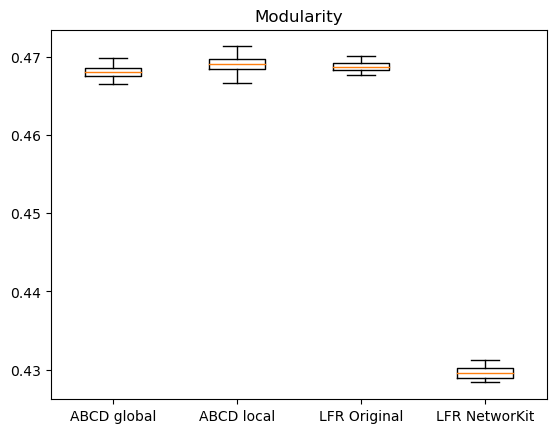

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall C:\Users\barto\.julia\packages\PyCall\3fwVL\src\numpy.jl:67


PyObject Text(0.5, 1.0, 'Modularity')

In [11]:
attr = :modularity

data = [get_plot_data("ABCD", "false", attr), get_plot_data("ABCD", "true", attr),
            get_plot_data("LFRog", "", attr), get_plot_data("LFR", "", attr)]
minlen = minimum(length.(data))
boxplot(hcat([data[i][1:minlen] for i = 1:length(data)]...))
xticks([1,2,3,4],["ABCD global", "ABCD local",  "LFR Original", "LFR NetworKit"])
title("Modularity")

#saving to a file:
#savefig("$(attr)_boxplot.eps")

In [12]:
gen_diff_table(attr, savetable = false)

|                |         ABCD Global |          ABCD  Local |     LFR  Original |       LFR  NetworKit |
| --------------:| -------------------:| --------------------:| -----------------:| --------------------:|
|    ABCD Global |                     |    0.0 0.0016 0.0051 | 0.0 0.0006 0.0023 |  0.002 0.0303 0.0678 |
|    ABCD  Local |   0.0 0.0016 0.0051 |                      |  0.0 0.001 0.0043 | 0.0045 0.0336 0.0681 |
|  LFR  Original |   0.0 0.0006 0.0023 |     0.0 0.001 0.0043 |                   |    0.0 0.0306 0.0677 |
| LFR  NetworKit | 0.002 0.0303 0.0678 | 0.0045 0.0336 0.0681 | 0.0 0.0306 0.0677 |                      |


### Global Clustering Coefficient

In [13]:
#Parameters:

ξ = 0.5
β = 1.5
γ = 2.5
min_deg = 5

5

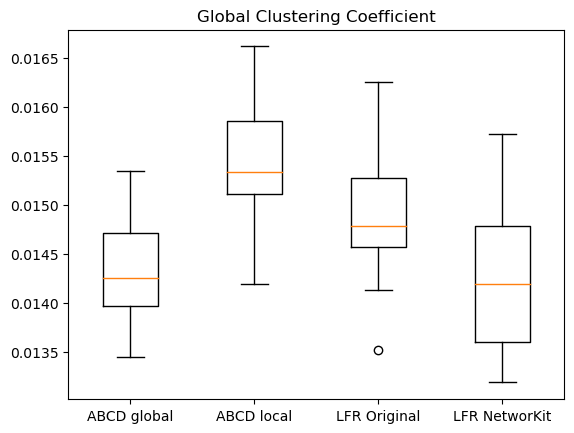

PyObject Text(0.5, 1.0, 'Global Clustering Coefficient')

In [14]:
attr = :global_coeff

data = [get_plot_data("ABCD", "false", attr), get_plot_data("ABCD", "true", attr),
            get_plot_data("LFRog", "", attr), get_plot_data("LFR", "", attr)]
minlen = minimum(length.(data))
boxplot(hcat([data[i][1:minlen] for i = 1:length(data)]...))
xticks([1,2,3,4],["ABCD global", "ABCD local",  "LFR Original", "LFR NetworKit"])
title("Global Clustering Coefficient")

#saving to a file:
#savefig("$(attr)_boxplot.eps")

In [15]:
gen_diff_table(attr, savetable = false)

|                |         ABCD Global |         ABCD  Local |     LFR  Original |    LFR  NetworKit |
| --------------:| -------------------:| -------------------:| -----------------:| -----------------:|
|    ABCD Global |                     | 0.0001 0.001 0.0024 | 0.0 0.0011 0.0084 | 0.0 0.0012 0.0064 |
|    ABCD  Local | 0.0001 0.001 0.0024 |                     | 0.0 0.0014 0.0088 | 0.0 0.0019 0.0074 |
|  LFR  Original |   0.0 0.0011 0.0084 |   0.0 0.0014 0.0088 |                   | 0.0 0.0007 0.0039 |
| LFR  NetworKit |   0.0 0.0012 0.0064 |   0.0 0.0019 0.0074 | 0.0 0.0007 0.0039 |                   |


### Average Local Clustering Coefficient

In [16]:
#Parameters:

ξ = 0.5
β = 1.5
γ = 2.5
min_deg = 5

5

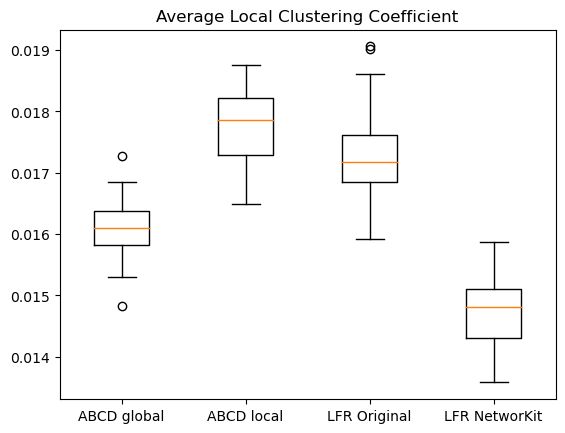

PyObject Text(0.5, 1.0, 'Average Local Clustering Coefficient')

In [17]:
attr = :avg_local_coeff

data = [get_plot_data("ABCD", "false", attr), get_plot_data("ABCD", "true", attr),
            get_plot_data("LFRog", "", attr), get_plot_data("LFR", "", attr)]
minlen = minimum(length.(data))
boxplot(hcat([data[i][1:minlen] for i = 1:length(data)]...))
xticks([1,2,3,4],["ABCD global", "ABCD local",  "LFR Original", "LFR NetworKit"])
title("Average Local Clustering Coefficient")

#saving to a file:
#savefig("$(attr)_boxplot.eps")

In [18]:
gen_diff_table(attr, savetable = false)

|                |       ABCD Global |       ABCD  Local |     LFR  Original |    LFR  NetworKit |
| --------------:| -----------------:| -----------------:| -----------------:| -----------------:|
|    ABCD Global |                   | 0.0 0.0015 0.0049 |  0.0 0.001 0.0078 |  0.0 0.002 0.0213 |
|    ABCD  Local | 0.0 0.0015 0.0049 |                   | 0.0 0.0007 0.0073 | 0.0 0.0035 0.0221 |
|  LFR  Original |  0.0 0.001 0.0078 | 0.0 0.0007 0.0073 |                   |  0.0 0.0026 0.019 |
| LFR  NetworKit |  0.0 0.002 0.0213 | 0.0 0.0035 0.0221 |  0.0 0.0026 0.019 |                   |


### $\delta$ + k cores

In [19]:
#Parameters:

ξ = 0.5
β = 1.5
γ = 2.5
min_deg = 5

5

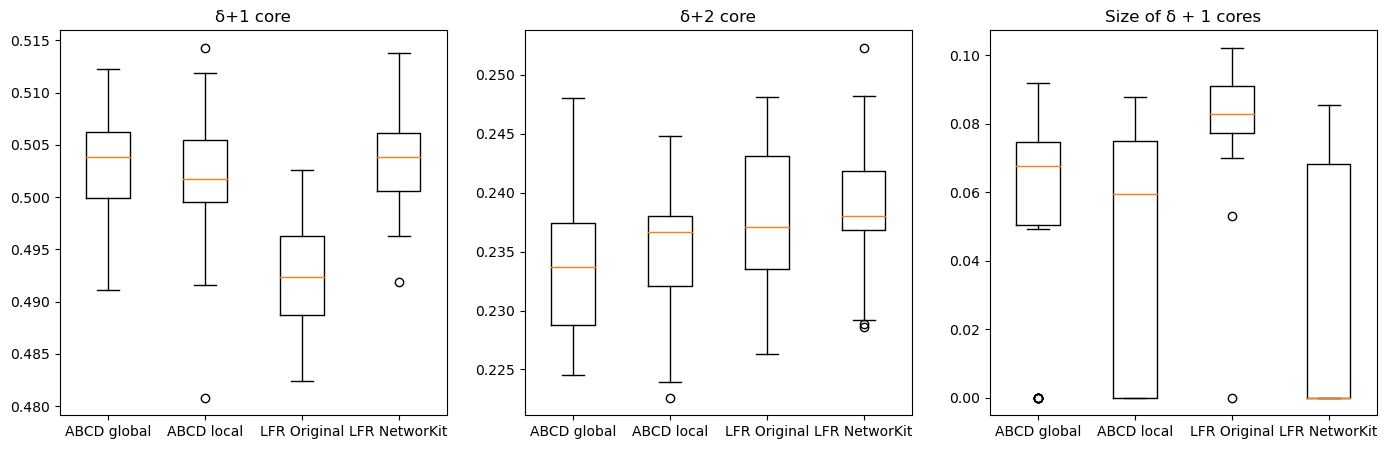

PyObject Text(0.5, 1.0, 'Size of δ + 1 cores')

In [20]:
fig = figure("δ + k cores",figsize = (17,5)) # Create a new blank figure
subplot(131)
attr = Symbol("δ+1")
data = [get_plot_data("ABCD", "false", attr), get_plot_data("ABCD", "true", attr),
            get_plot_data("LFRog", "", attr), get_plot_data("LFR", "", attr)]
minlen = minimum(length.(data))
boxplot(hcat([data[i][1:minlen] for i = 1:length(data)]...))
xticks([1,2,3,4],["ABCD global", "ABCD local",  "LFR Original", "LFR NetworKit"])
PyPlot.title("δ+1 core") 
subplot(132)
attr = Symbol("δ+2")
data = [get_plot_data("ABCD", "false", attr), get_plot_data("ABCD", "true", attr),
            get_plot_data("LFRog", "", attr), get_plot_data("LFR", "", attr)]
minlen = minimum(length.(data))
boxplot(hcat([data[i][1:minlen] for i = 1:length(data)]...))
xticks([1,2,3,4],["ABCD global", "ABCD local",  "LFR Original", "LFR NetworKit"])
PyPlot.title("δ+2 core") 
subplot(133)
attr = Symbol("δ+3")
data = [get_plot_data("ABCD", "false", attr), get_plot_data("ABCD", "true", attr),
            get_plot_data("LFRog", "", attr), get_plot_data("LFR", "", attr)]
minlen = minimum(length.(data))
boxplot(hcat([data[i][1:minlen] for i = 1:length(data)]...))
xticks([1,2,3,4],["ABCD global", "ABCD local",  "LFR Original", "LFR NetworKit"])
PyPlot.title("δ+3 core") 
title("Size of δ + 1 cores")

#saving to a file:
#savefig("core_boxplot.eps")

# Robustness and Giant Component size

Plot show the giant component size and robustness of the graph (size of the giant component after removal of $p$ percent of the nodes with the highest degree, relatively to the size of the original graph)

In [21]:
ps = [0.05, 0.1, 0.15];

In [22]:
#Parameters:

ξ = 0.2
β = 1.5
γ = 2.5
min_deg = 5
p = 0.1

0.1

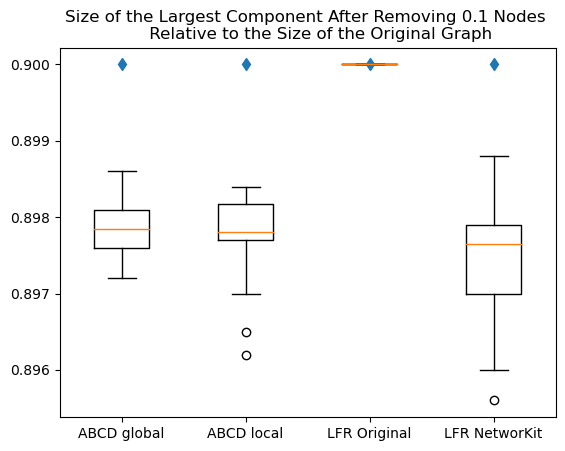

PyObject Text(0.5, 1.0, 'Size of the Largest Component After Removing 0.1 Nodes \n     Relative to the Size of the Original Graph')

In [23]:
attr = Symbol("size_$p")
data = [get_plot_data("ABCD", "false", attr), get_plot_data("ABCD", "true", attr),
            get_plot_data("LFRog", "", attr), get_plot_data("LFR", "", attr)]
minlen = minimum(length.(data))
boxplot(hcat([data[i][1:minlen] for i = 1:length(data)]...))
plot(1:4, (1.0 - p).* ones(4), "d")
xticks([1,2,3,4],["ABCD global", "ABCD local",  "LFR Original", "LFR NetworKit"])
PyPlot.title("Size of the Largest Component After Removing $p Nodes 
     Relative to the Size of the Original Graph") 

#saving to a file:
#savefig("$(attr)_boxplot.eps")

In [24]:
gen_diff_table(attr, savetable = false)

|                |          ABCD Global |          ABCD  Local |        LFR  Original |       LFR  NetworKit |
| --------------:| --------------------:| --------------------:| --------------------:| --------------------:|
|    ABCD Global |                      |      0.0 0.0108 0.09 | 0.0008 0.0073 0.0909 |      0.0 0.0093 0.09 |
|    ABCD  Local |      0.0 0.0108 0.09 |                      | 0.0008 0.0103 0.0661 |    0.0 0.0102 0.0601 |
|  LFR  Original | 0.0008 0.0073 0.0909 | 0.0008 0.0103 0.0661 |                      | 0.0007 0.0082 0.0649 |
| LFR  NetworKit |      0.0 0.0093 0.09 |    0.0 0.0102 0.0601 | 0.0007 0.0082 0.0649 |                      |


In [25]:
#Parameters:

ξ = 0.5
β = 1.5
γ = 2.5
min_deg = 5

5

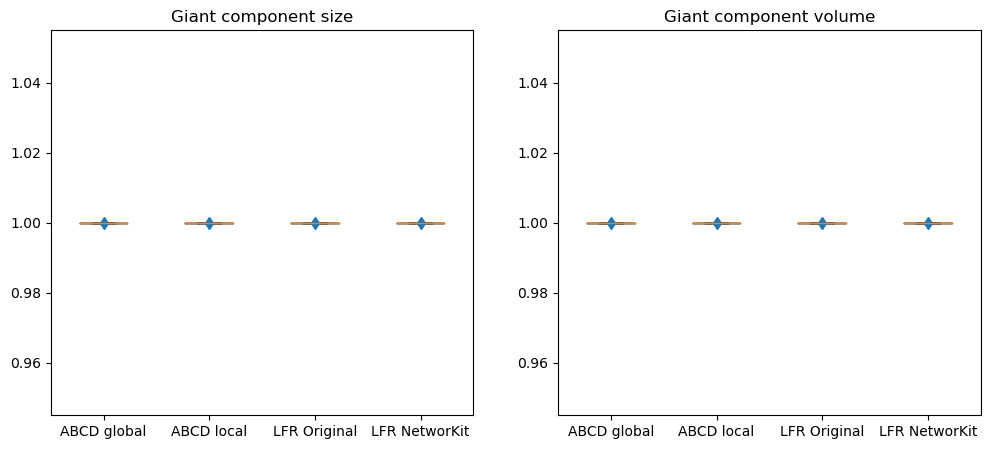

PyObject Text(0.5, 1.0, 'Giant component volume')

In [26]:
ig = figure("Giant Component Size and Volume",figsize = (12,5)) # Create a new blank figure
subplot(121)
attr = :giant_component_size
data = [get_plot_data("ABCD", "false", attr), get_plot_data("ABCD", "true", attr),
            get_plot_data("LFRog", "", attr), get_plot_data("LFR", "", attr)]
minlen = minimum(length.(data))
boxplot(hcat([data[i][1:minlen] for i = 1:length(data)]...))
plot(1:4, ones(4), "d")
xticks([1,2,3,4],["ABCD global", "ABCD local",  "LFR Original", "LFR NetworKit"])
PyPlot.title("Giant component size") 
subplot(122)
attr = :giant_component_volume
data = [get_plot_data("ABCD", "false", attr), get_plot_data("ABCD", "true", attr),
            get_plot_data("LFRog", "", attr), get_plot_data("LFR", "", attr)]
minlen = minimum(length.(data))
boxplot(hcat([data[i][1:minlen] for i = 1:length(data)]...))
plot(1:4, ones(4), "d")
xticks([1,2,3,4],["ABCD global", "ABCD local",  "LFR Original", "LFR NetworKit"])
PyPlot.title("Giant component volume") 

#saving to a file:
#savefig("gc_size_and_vol_boxplot.eps")

# Proportion of Internal Edges

In [27]:
#Parameters:

ξ = 0.5
β = 1.5
γ = 2.5
min_deg = 5

5

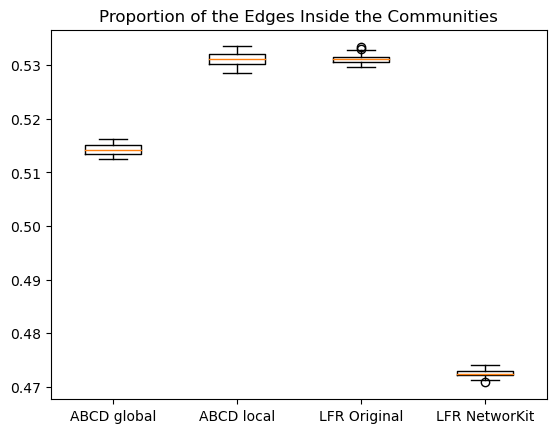

PyObject Text(0.5, 1.0, 'Proportion of the Edges Inside the Communities')

In [28]:
attr = :internal_edges_mean
data = [get_plot_data("ABCD", "false", attr), get_plot_data("ABCD", "true", attr),
            get_plot_data("LFRog", "", attr), get_plot_data("LFR", "", attr)]
minlen = minimum(length.(data))
boxplot(hcat([data[i][1:minlen] for i = 1:length(data)]...))
xticks([1,2,3,4],["ABCD global", "ABCD local",  "LFR Original", "LFR NetworKit"])
PyPlot.title("Proportion of the Edges Inside the Communities") 

#saving to a file:
#savefig("$(attr)_boxplot.eps")

In [29]:
gen_diff_table(attr, savetable = false)

|                |          ABCD Global |          ABCD  Local |        LFR  Original |       LFR  NetworKit |
| --------------:| --------------------:| --------------------:| --------------------:| --------------------:|
|    ABCD Global |                      | 0.0016 0.0211 0.0499 | 0.0017 0.0229 0.0548 | 0.0001 0.0357 0.1177 |
|    ABCD  Local | 0.0016 0.0211 0.0499 |                      |    0.0 0.0004 0.0018 |  0.0011 0.046 0.0977 |
|  LFR  Original | 0.0017 0.0229 0.0548 |    0.0 0.0004 0.0018 |                      | 0.0001 0.0441 0.0977 |
| LFR  NetworKit | 0.0001 0.0357 0.1177 |  0.0011 0.046 0.0977 | 0.0001 0.0441 0.0977 |                      |


# Correlation coefficient and correlation exponent

In [30]:
#Parameters:

ξ = 0.5
β = 1.5
γ = 2.5
min_deg = 5

5

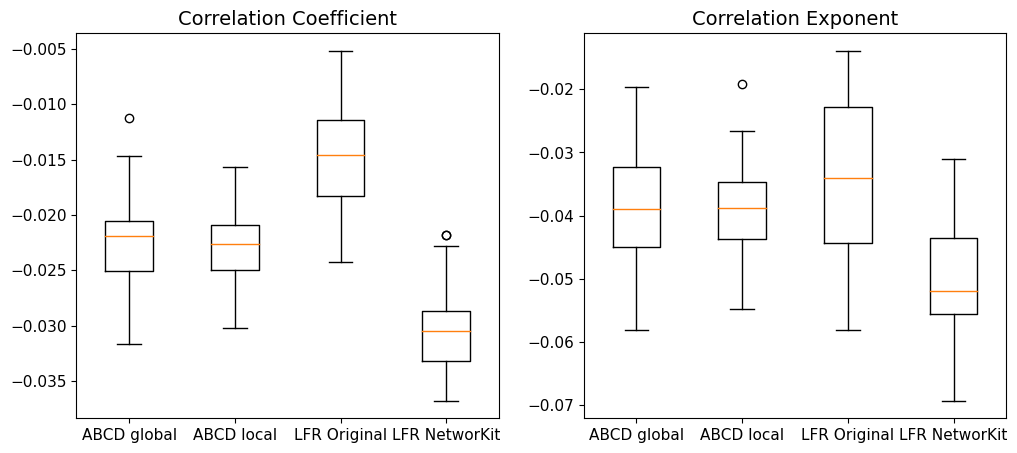

In [31]:
ig = figure("Correlation Coefficient and Correlation Exponent",figsize = (12,5)) # Create a new blank figure
subplot(121)
attr = :correlation_coeff
data = [get_plot_data("ABCD", "false", attr), get_plot_data("ABCD", "true", attr),
            get_plot_data("LFRog", "", attr), get_plot_data("LFR", "", attr)]
minlen = minimum(length.(data))
boxplot(hcat([data[i][1:minlen] for i = 1:length(data)]...))
xticks([1,2,3,4],["ABCD global", "ABCD local",  "LFR Original", "LFR NetworKit"], fontsize = 11)
yticks(fontsize = 11)
PyPlot.title("Correlation Coefficient", fontsize = 14) 
subplot(122)
attr = :corr_exp
data = [get_plot_data("ABCD", "false", attr), get_plot_data("ABCD", "true", attr),
            get_plot_data("LFRog", "", attr), get_plot_data("LFR", "", attr)]
minlen = minimum(length.(data))
boxplot(hcat([data[i][1:minlen] for i = 1:length(data)]...))
xticks([1,2,3,4],["ABCD global", "ABCD local",  "LFR Original", "LFR NetworKit"], fontsize = 11)
yticks(fontsize = 11)
PyPlot.title("Correlation Exponent", fontsize = 14) 

#saving to a file:
savefig("correlation_boxplots.eps")

In [32]:
attr = :correlation_coeff
gen_diff_table(attr, savetable = false)

|                |          ABCD Global |          ABCD  Local |        LFR  Original |       LFR  NetworKit |
| --------------:| --------------------:| --------------------:| --------------------:| --------------------:|
|    ABCD Global |                      |    0.0 0.0014 0.0041 | 0.0001 0.0087 0.0215 |    0.0 0.0071 0.0183 |
|    ABCD  Local |    0.0 0.0014 0.0041 |                      | 0.0001 0.0094 0.0217 | 0.0001 0.0065 0.0184 |
|  LFR  Original | 0.0001 0.0087 0.0215 | 0.0001 0.0094 0.0217 |                      | 0.0002 0.0126 0.0215 |
| LFR  NetworKit |    0.0 0.0071 0.0183 | 0.0001 0.0065 0.0184 | 0.0002 0.0126 0.0215 |                      |


In [33]:
attr = :corr_exp
gen_diff_table(attr, savetable = false)

|                |          ABCD Global |          ABCD  Local |        LFR  Original |       LFR  NetworKit |
| --------------:| --------------------:| --------------------:| --------------------:| --------------------:|
|    ABCD Global |                      |    0.0 0.0022 0.0064 | 0.0001 0.0088 0.0248 | 0.0003 0.0101 0.0225 |
|    ABCD  Local |    0.0 0.0022 0.0064 |                      |  0.0001 0.0099 0.024 | 0.0003 0.0093 0.0213 |
|  LFR  Original | 0.0001 0.0088 0.0248 |  0.0001 0.0099 0.024 |                      |    0.0 0.0147 0.0262 |
| LFR  NetworKit | 0.0003 0.0101 0.0225 | 0.0003 0.0093 0.0213 |    0.0 0.0147 0.0262 |                      |


# KNN function plots

In [34]:
#Parameters:

ξ = 0.5
β = 1.5
γ = 2.5
min_deg = 5
λ  = 1000.0

1000.0

### Separate plots

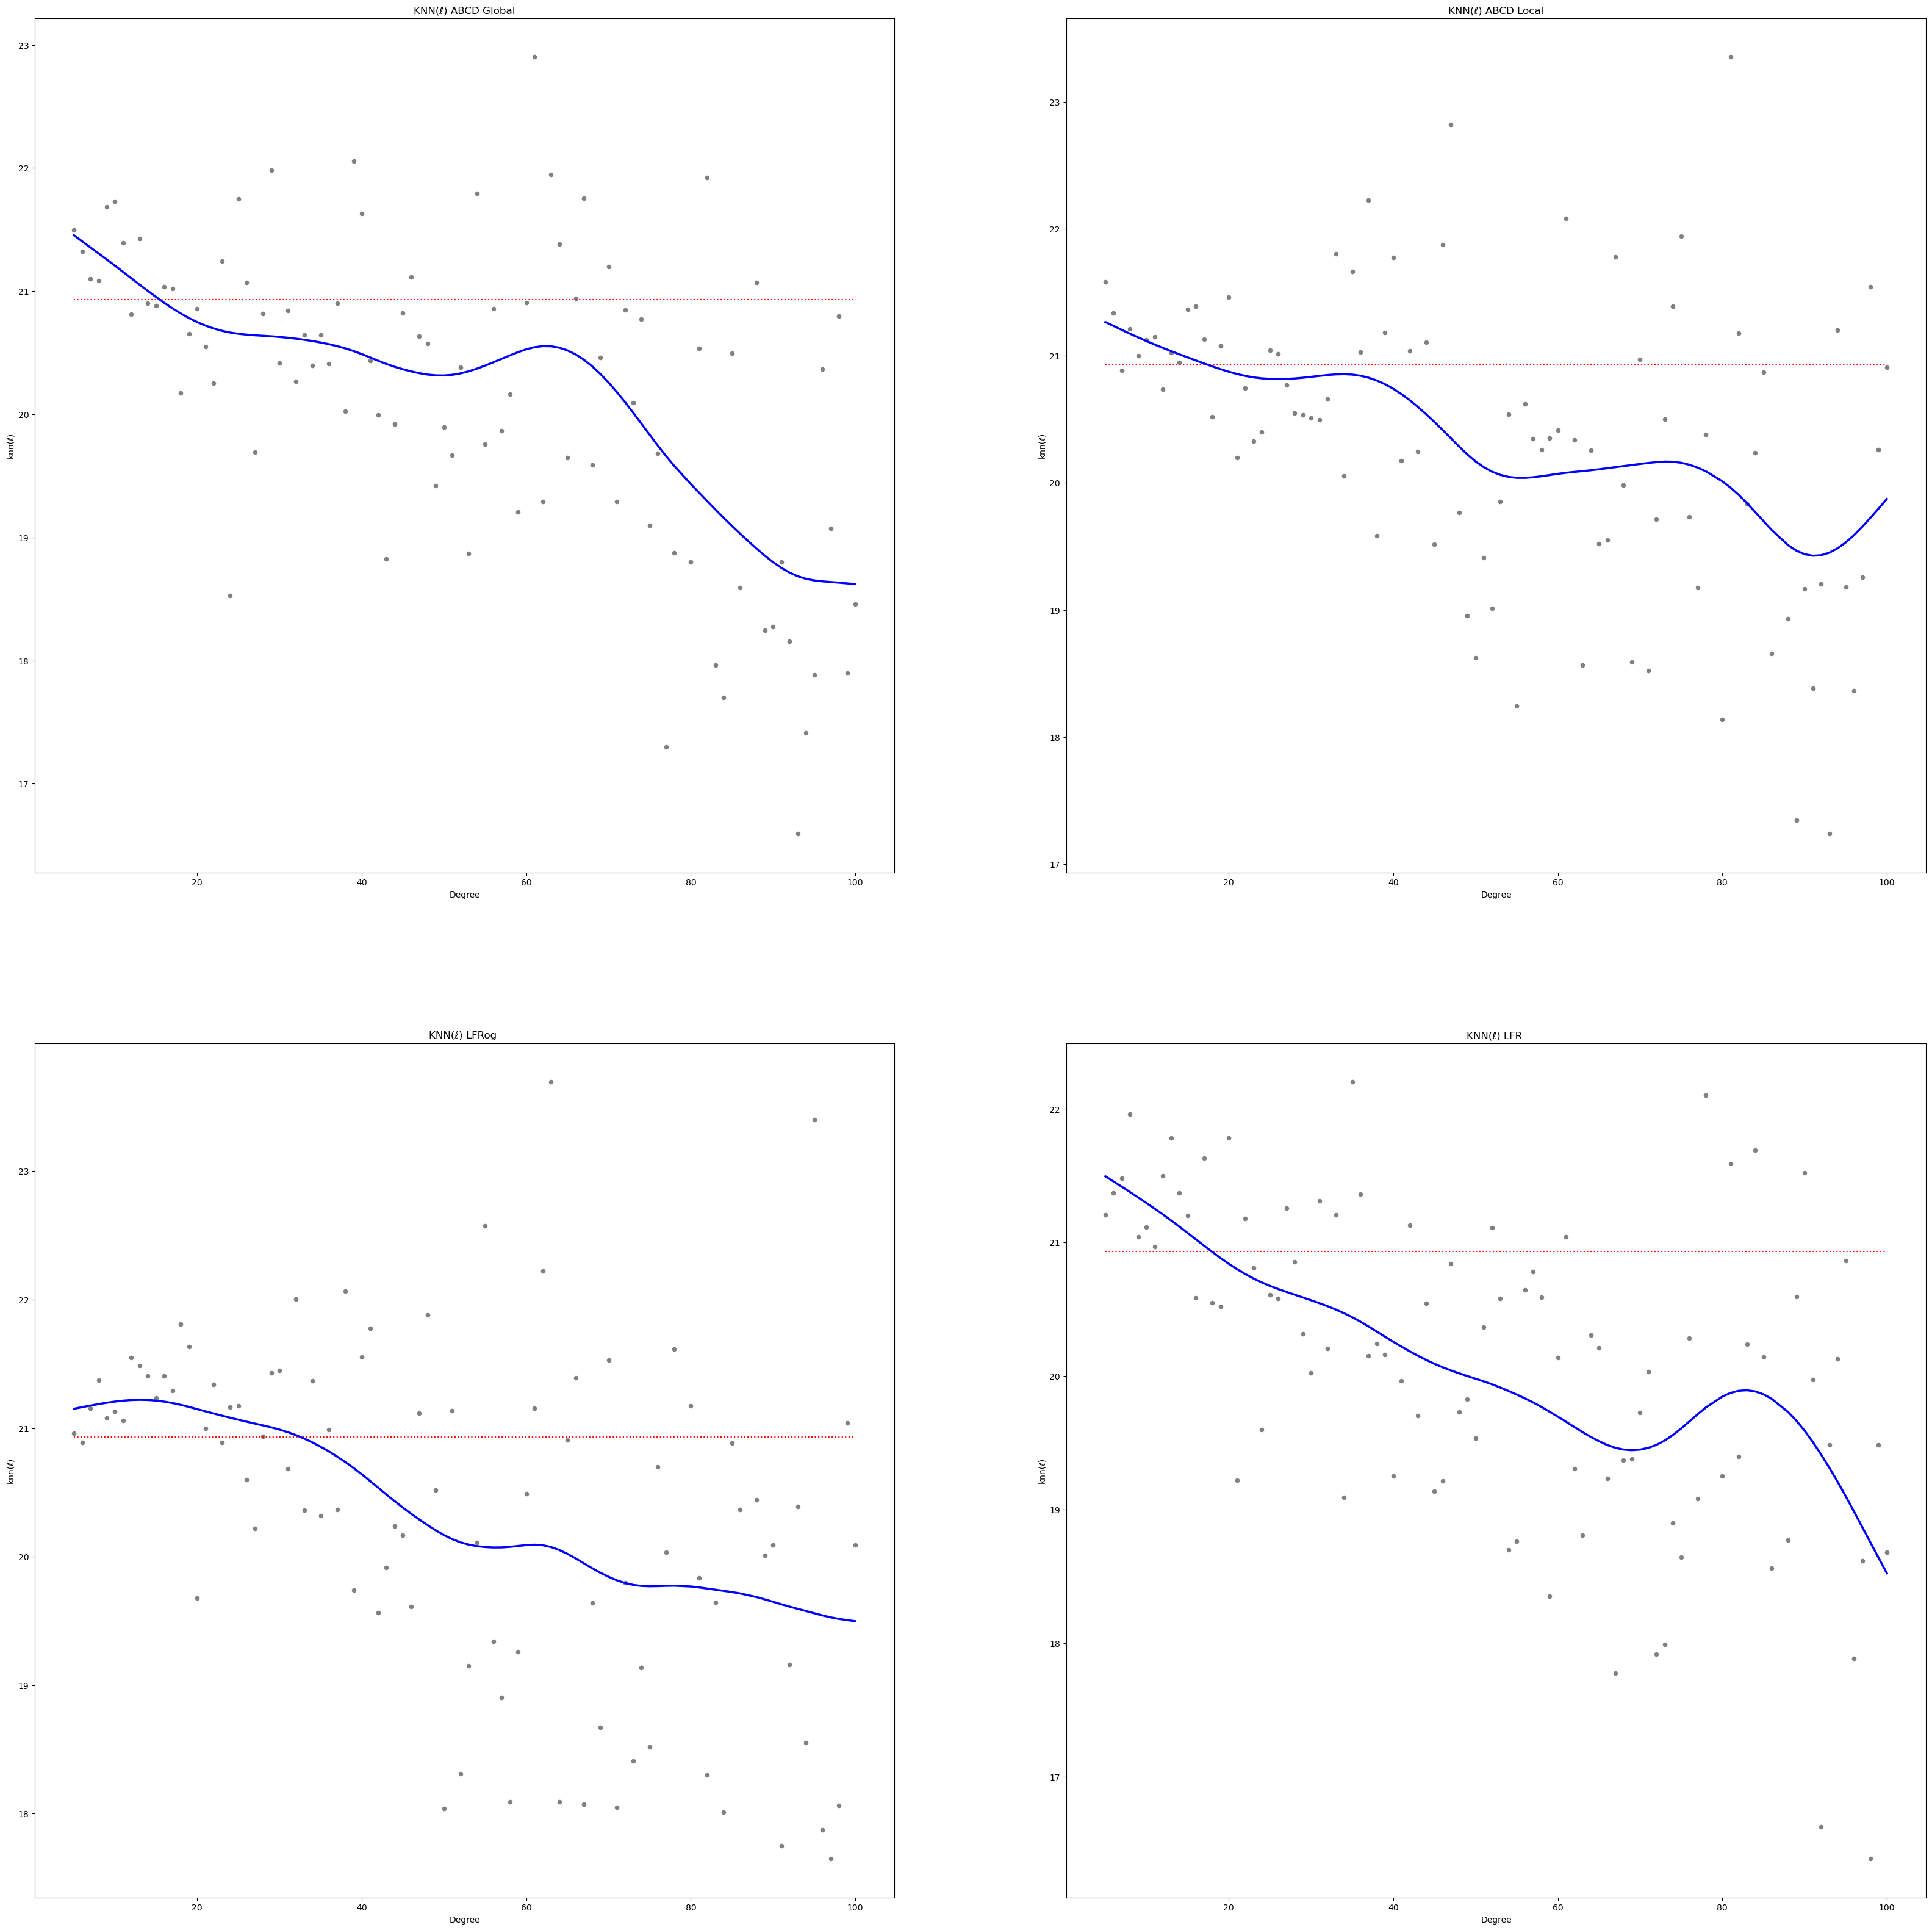

In [35]:
fig = figure("KNN plots",figsize = (40,40))
k = 1
for (algo, islocal) in [("ABCD", false),("ABCD", true),("LFRog", ""), ("LFR", "")]
    subplot(parse(Int, "22" * "$k"))
    (typeof(islocal) == Bool) ? (islocal ? algtype = "Local" : algtype = "Global") : algtype = ""
    algo == "LFRog" ? (name = graphdir * "$(algo)_1_$(n)_$(ξ)_$(β)_$(γ)_$(min_deg)_$(islocal).nse"; start = 2) :
    (name = graphdir * "$(algo)_1_$(n)_$(ξ)_$(β)_$(γ)_$(min_deg)_$(islocal).dat"; start = 1)
    g = SimpleGraphFromIterator([Graphs.SimpleEdge(parse.(Int,e[1]),parse.(Int,e[2])) 
                    for e in split.(readlines(name))[start:end]])
    x = sort(unique(degree(g)))
    y = degree_correlation(g)
    r = deg_corr_neutral(g, degree)
    hlines(y=r,xmin=minimum(x),xmax=maximum(x),linestyles=":", color = "red")
    scatter(x,y, color = "gray", s = 20)
    spl = fit(SmoothingSpline, Float64.(x), y, λ)
    y_pred = predict(spl)
    plot(x, y_pred, "blue", linewidth=2.5)
    xlabel("Degree")
    ylabel("knn(ℓ)")
    PyPlot.title("KNN(ℓ) $algo $algtype") 
    k +=1
end

#saving to a file:
#savefig("KNN_4_plots.eps")

### One plot:

In [36]:
#Parameters:

ξ = 0.5
β = 1.5
γ = 2.5
min_deg = 5
λ  = 1000.0

1000.0

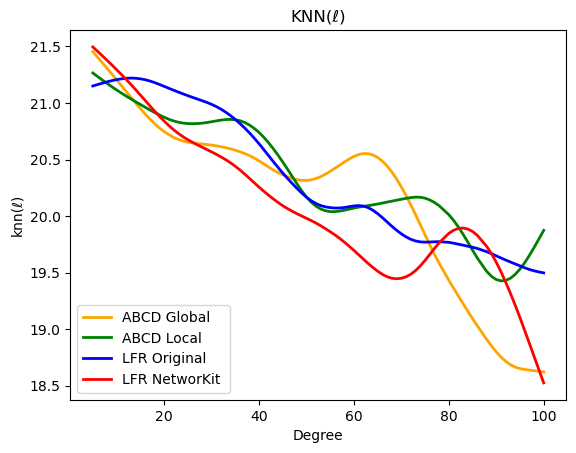

In [37]:
for (algo, islocal, color) in [("ABCD", false, "orange"),("ABCD", true, "green"),
        ("LFRog", "", "blue"), ("LFR", "", "red")]
    (typeof(islocal) == Bool) ? (islocal ? algtype = "Local" : algtype = "Global") : algtype = ""
    algo == "LFRog" ? (name = graphdir * "$(algo)_1_$(n)_$(ξ)_$(β)_$(γ)_$(min_deg)_$(islocal).nse"; start = 2) :
    (name = graphdir * "$(algo)_1_$(n)_$(ξ)_$(β)_$(γ)_$(min_deg)_$(islocal).dat"; start = 1)
    g = SimpleGraphFromIterator([Graphs.SimpleEdge(parse.(Int,e[1]),parse.(Int,e[2])) 
                    for e in split.(readlines(name))[start:end]])
    x = sort(unique(degree(g)))
    y = degree_correlation(g)
    spl = fit(SmoothingSpline, Float64.(x), y, λ)
    y_pred = predict(spl)
    algo == "LFRog" ? algo = "LFR Original" : (algo == "LFR" && (algo = "LFR NetworKit"))
    plot(x, y_pred, linewidth=2, label = "$algo $algtype", c = color)
    legend(loc="lower left")
    xlabel("Degree")
    ylabel("knn(ℓ)")
    PyPlot.title("KNN(ℓ)") 
end

#saving to a file:
#savefig("KNN_plot.eps")

# Shortest path length

Dijkstra's algorithm was perform on a graph, computing shortest distances between source nodes (sampled 10% of nodes) and all other vertices. Then descriptive statistics were calculated. 

In [38]:
#Parameters:

ξ = 0.5
β = 1.5
γ = 2.5
min_deg = 5

5

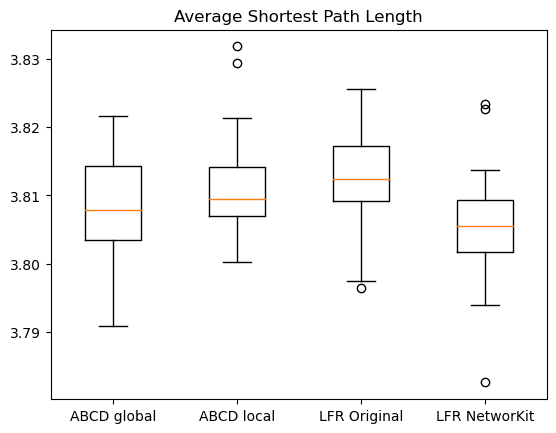

PyObject Text(0.5, 1.0, 'Average Shortest Path Length')

In [39]:
attr = :avg

data = [get_plot_data("ABCD", "false", attr, fname = "paths", colnames = colnames2),
    get_plot_data("ABCD", "true", attr, fname = "paths", colnames = colnames2),
    get_plot_data("LFRog", "", attr,  fname = "paths", colnames = colnames2),
            get_plot_data("LFR", "", attr,  fname = "paths", colnames = colnames2)]
minlen = minimum(length.(data))
boxplot(hcat([data[i][1:minlen] for i = 1:length(data)]...))
xticks([1,2,3,4],["ABCD global", "ABCD local",  "LFR Original", "LFR NetworKit"])
title("Average Shortest Path Length")

#saving to a file:
#savefig("shortest_path_boxplot.eps")

In [40]:
gen_diff_table(attr, savetable = false, fname = "paths", colnames = colnames2)

|                |          ABCD Global |          ABCD  Local |                                 LFR  Original |                                LFR  NetworKit |
| --------------:| --------------------:| --------------------:| ---------------------------------------------:| ---------------------------------------------:|
|    ABCD Global |                      | 0.0001 0.0031 0.0119 |                             0.0 0.0042 0.0129 |                              0.0 0.0147 0.223 |
|    ABCD  Local | 0.0001 0.0031 0.0119 |                      |                             0.0 0.0039 0.0131 |                          0.0001 0.0184 0.2201 |
|  LFR  Original |    0.0 0.0042 0.0129 |    0.0 0.0039 0.0131 |                                               | 0.0 1.699625289350412e15 5.707305787026944e16 |
| LFR  NetworKit |     0.0 0.0147 0.223 | 0.0001 0.0184 0.2201 | 0.0 1.699625289350412e15 5.707305787026944e16 |                                               |


# Centrality measures

In [41]:
centralities = [:betweenness_centrality, :closeness_centrality, :degree_centrality,  :pagerank];

### CDF plots

In [42]:
#Parameters:

ξ = 0.5
β = 1.5
γ = 2.5
min_deg = 5

5

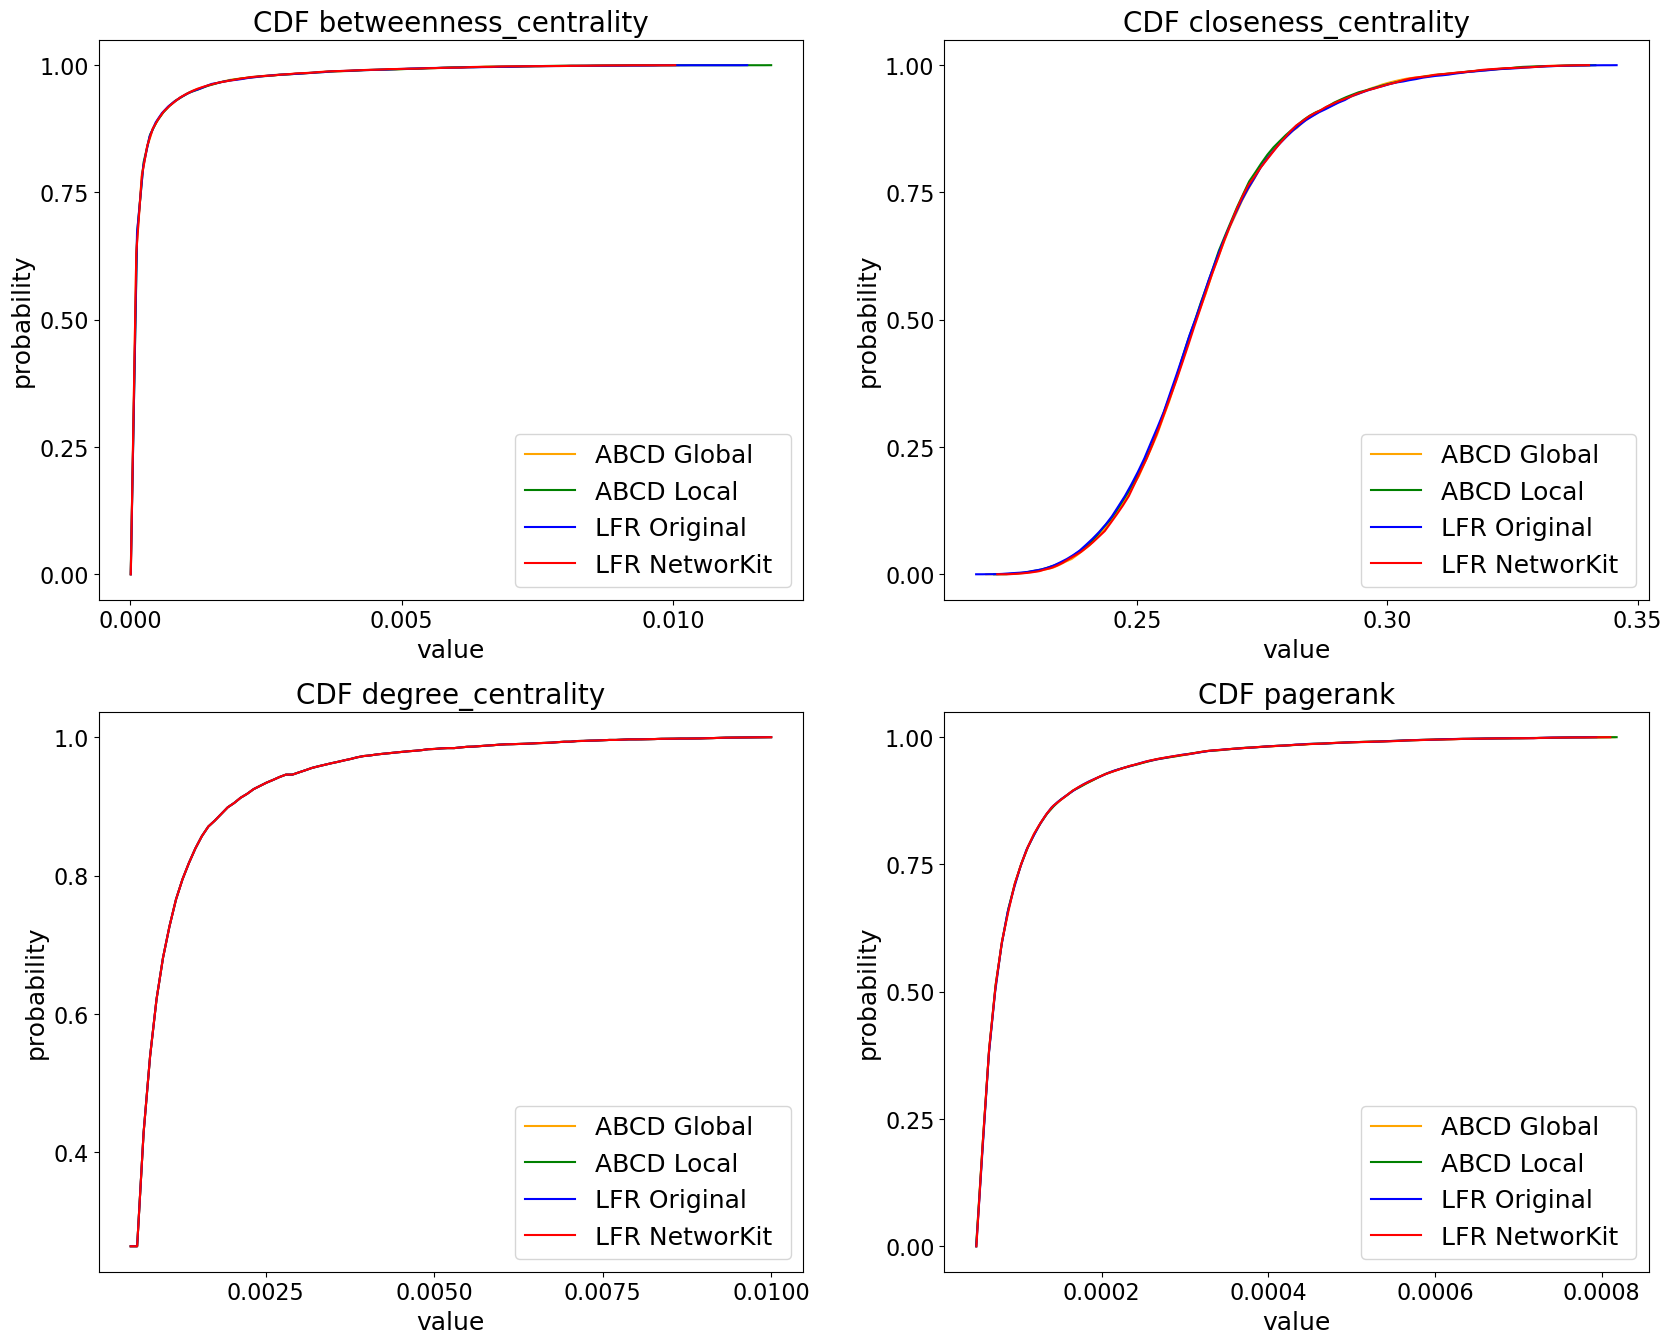

In [43]:
fig = figure("CDF for different centralities",figsize = (20,16))
k = 1
for centrality in Symbol.(centralities)
    subplot(parse(Int, "22" * "$k"))
    for (algo, islocal, color) in [("ABCD", false, "orange"),("ABCD", true, "green"),
        ("LFRog", "", "blue"), ("LFR", "", "red")]
        (typeof(islocal) == Bool) ? (islocal ? algtype = "Local" : algtype = "Global") : algtype = ""
        name = resdir * "$(centrality)/$(algo)_$(centrality)_raw_$(n)_$(ξ)_$(β)_$(γ)_$(min_deg)_$(islocal).dat"
        data =  parse.(Float64, reduce(hcat, split.(readlines(name), "\t")))
        algo == "LFRog" ? algo = "LFR Original" : (algo == "LFR" && (algo = "LFR NetworKit"))
        locator_params(nbins= 5)
        xticks(fontsize= 16)
        yticks(fontsize= 16)
        xlabel("value", fontsize= 18)
        ylabel("probability", fontsize= 18)
        plot(data[1,:],data[2,:], label = "$algo $algtype", c = color)
        legend(loc="lower right", fontsize= 18)  
        PyPlot.title("CDF $(centrality)", fontsize = 20) 
    end
    k += 1
end
#saving to a file:
#savefig("centrality_plots.eps")

# Nodes participation stats

### Average participation coefficient

In [44]:
#Parameters:

ξ = 0.7
β = 1.5
γ = 2.5
min_deg = 5

5

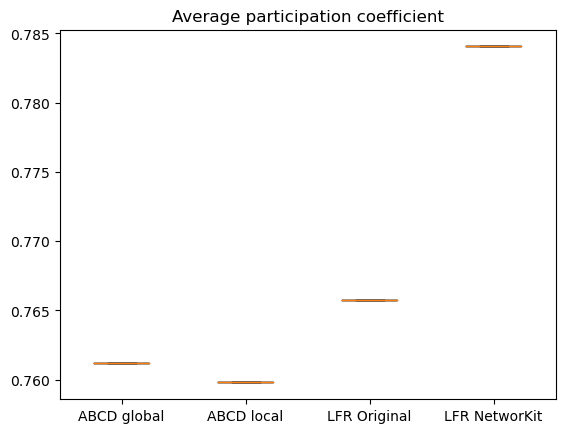

PyObject Text(0.5, 1.0, 'Average participation coefficient')

In [45]:
attr = :avg_part_coeff

data = [get_plot_data("ABCD", "false", attr, fname = "participation", colnames = colnames3),
    get_plot_data("ABCD", "true", attr, fname = "participation", colnames = colnames3),
    get_plot_data("LFRog", "", attr,  fname = "participation", colnames = colnames3),
            get_plot_data("LFR", "", attr,  fname = "participation", colnames = colnames3)]
minlen = minimum(length.(data))
boxplot(hcat([data[i][1:minlen] for i = 1:length(data)]...))
xticks([1,2,3,4],["ABCD global", "ABCD local",  "LFR Original", "LFR NetworKit"])
title("Average participation coefficient")

#saving to a file:
#savefig("$(attr)_boxplot.eps")

### Plot

In [46]:
#Parameters:

ξ = 0.7
β = 1.5
γ = 2.5
min_deg = 5

5

In [47]:
cnames = [:Algorithm, :Hubs, Symbol("Provincial Hubs"), Symbol("Connector Hubs"), Symbol("Kinless Hubs"), 
            Symbol("Ultra Peripheral Nodes"), Symbol("Peripheral Nodes"), 
        Symbol("Connector Nodes"), Symbol("Kinless Nodes")]
dt = DataFrame(cnames .=> fill([],length(cnames)))

for (algo, islocal) in [("ABCD", false),("ABCD", true),("LFRog", ""), ("LFR", "")]
    (typeof(islocal) == Bool) ? (islocal ? algtype = "Local" : algtype = "Global") : algtype = ""
    name = resdir * "$(algo)_participation_$(n)_$(ξ)_$(β)_$(γ)_$(min_deg)_$(islocal).dat"
    df = DataFrame(mean(Array(hcat([parse.(Float64, x) for x in split.(readlines(name),";")]...)'), dims = 1)
    , cnames)
    select!(df, Not(:Algorithm))
    algo == "LFRog" ? algo = "LFR Original" : (algo == "LFR" && (algo = "LFR NetworKit"))
    insertcols!(df, 1, :Algorithm => ["$algo $algtype"])
    dt = vcat(dt,df)        
end

dt[:,2:end] = round.(dt[:,2:end], digits=4);

Participation table:

In [48]:
[:Algorithm, :Hubs, Symbol("Provincial Hubs"), Symbol("Connector Hubs"), Symbol("Kinless Hubs"), 
            Symbol("Ultra Peripheral Nodes"), Symbol("Peripheral Nodes"), 
        Symbol("Connector Nodes"), Symbol("Kinless Nodes")];

In [49]:
table = dt[!,[:Algorithm, :Hubs, Symbol("Ultra Peripheral Nodes"), Symbol("Peripheral Nodes"), 
        Symbol("Connector Nodes"), Symbol("Kinless Nodes")]]

#save table in latex format:
#open("participation_table.tex", "w") do file
#    write(file, latextabular(table, latex=false))
#end
#latexify(table, latex=false)

,Algorithm,Hubs,Ultra Peripheral Nodes,Peripheral Nodes,Connector Nodes
,Any,Any,Any,Any,Any
1,ABCD Global,0.0335,0.0001,0.0536,0.6344
2,ABCD Local,0.0332,0.0,0.0497,0.6506
3,LFR Original,0.0328,0.0,0.0114,0.7011
4,LFR NetworKit,0.0334,0.0,0.0143,0.6249


Hubs structure:

In [50]:
table = dt[!,[:Algorithm, Symbol("Provincial Hubs"), Symbol("Connector Hubs"), Symbol("Kinless Hubs")]]

#save table in latex format:
#open("hubs.tex", "w") do file
#    write(file, latextabular(table, latex=false))
#end
#latexify(table, latex=false)

,Algorithm,Provincial Hubs,Connector Hubs,Kinless Hubs
,Any,Any,Any,Any
1,ABCD Global,0.0,0.0239,0.9761
2,ABCD Local,0.0,0.0181,0.9819
3,LFR Original,0.0,0.0,1.0
4,LFR NetworKit,0.0,0.003,0.997


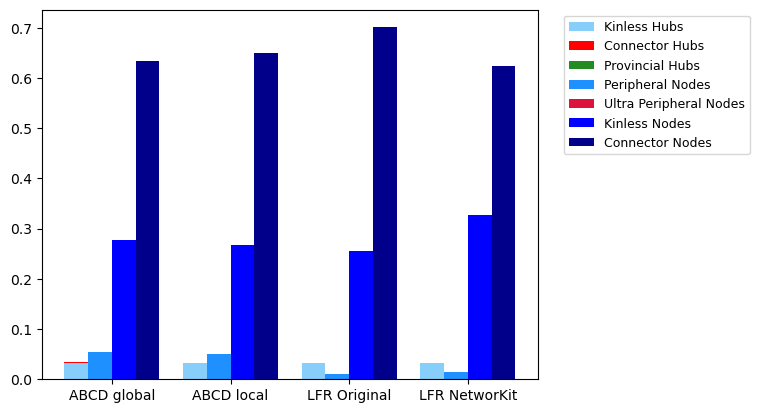

PyObject <matplotlib.legend.Legend object at 0x00000000023E9EB0>

In [51]:
N = 1:1:4
width = 0.2
logscale = false #scale of the plot

kinless_hubs = dt[!,:Hubs] .*  dt[!,Symbol("Kinless Hubs")]
connector_hubs = dt[!,:Hubs] .*  dt[!, Symbol("Connector Hubs")]
provincial_hubs = dt[!,:Hubs] .*  dt[!,Symbol("Provincial Hubs")]

bar(N .+ 0.00, kinless_hubs, width = width, label = "Kinless Hubs", color = "lightskyblue")
bar(N .+ 0.00, connector_hubs, width = width, bottom = kinless_hubs, label = "Connector Hubs", color= "red")
bar(N .+ 0.00, provincial_hubs, width = width, bottom = connector_hubs, label = "Provincial Hubs", 
    color = "forestgreen")
bar(N .+ 0.20, dt[!,Symbol("Peripheral Nodes")], width = width, label = "Peripheral Nodes", color = "dodgerblue")
bar(N .+ 0.20, dt[!, Symbol("Ultra Peripheral Nodes")], width = width, label = "Ultra Peripheral Nodes",
    bottom = dt[!,Symbol("Peripheral Nodes")], color = "crimson")
bar(N .+ 0.40, dt[!,Symbol("Kinless Nodes")], width = width, label = "Kinless Nodes", color = "blue")
bar(N .+ 0.60, dt[!,Symbol("Connector Nodes")], width = width, label = "Connector Nodes", color = "darkblue")


logscale && yscale("log")
xticks(N .+ 0.3,["ABCD global", "ABCD local", "LFR Original", "LFR NetworKit"])
legend(bbox_to_anchor=(1.04,1), loc="upper left", fontsize = 9)
#tight_layout()
#saving to a file:
#savefig("participation_plots.eps", bbox_inches="tight")

# Boxplots for different values of $\beta$'s and $\gamma$'s

In [52]:
#Parameters:

ξ = 0.5
β = 1.5
γ = 2.5
min_deg = 5
attr = :modularity;
cname, fname = colnames, "stats";

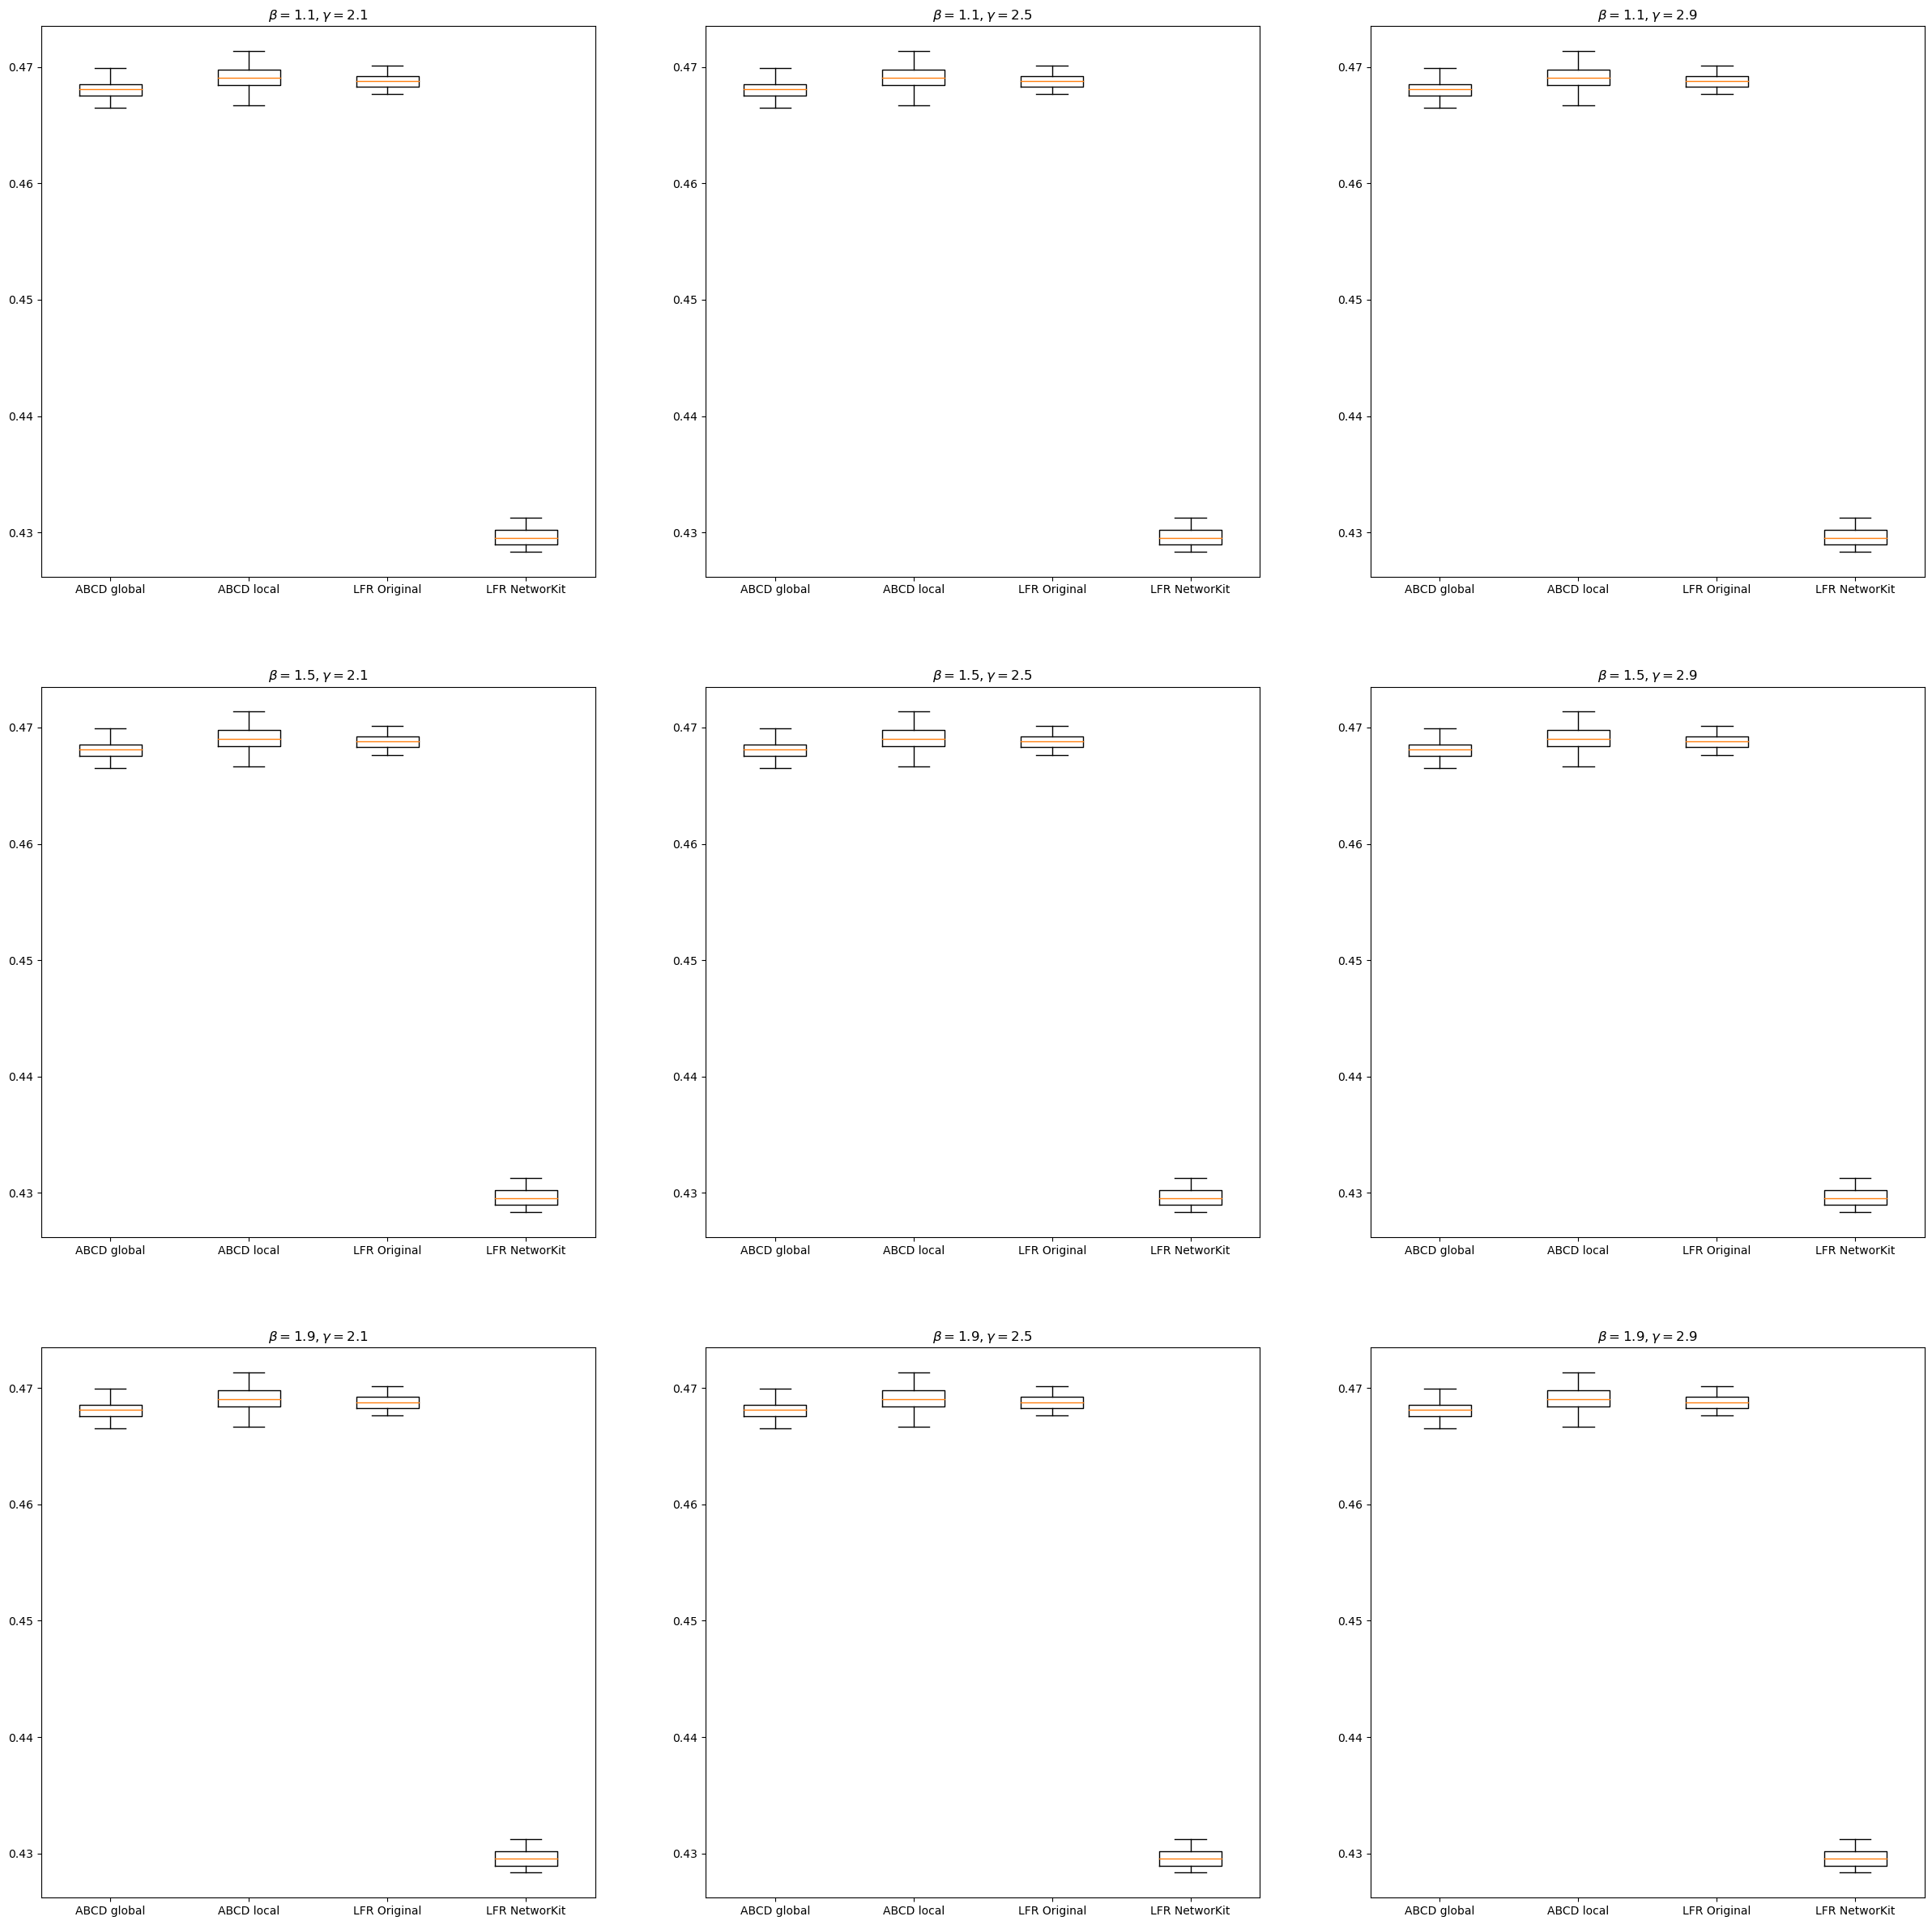

In [53]:
fig = figure(L"%$(attr) for Different Values of $β$ and $γ$",figsize = (30,30)) 
k = 1
for (i,β) in enumerate(βs)
    for (j,γ) in enumerate(γs)
        subplot(parse(Int, "33" * "$k"))
        data = [get_plot_data("ABCD", "false", attr, fname = fname, colnames = cname),
            get_plot_data("ABCD", "true", attr, fname = fname, colnames = cname),
            get_plot_data("LFRog", "", attr,  fname = fname, colnames = cname),
            get_plot_data("LFR", "", attr,  fname = fname, colnames = cname)]
        minlen = minimum(length.(data))
        boxplot(hcat([data[i][1:minlen] for i = 1:length(data)]...))
        xticks([1,2,3,4],["ABCD global", "ABCD local",  "LFR Original", "LFR NetworKit"])
        PyPlot.title(L"β = %$β, γ = %$γ") 
        k += 1
    end
end

#saving to a file:
#savefig("$(attr)_boxplot_beta_gamma.eps")

# Plot for different $\xi$'s

### Separate plots

In [54]:
#Parameters:

ξ = 0.5
β = 1.5
γ = 2.5
min_deg = 5
attr = :global_coeff
α = 0.05

0.05

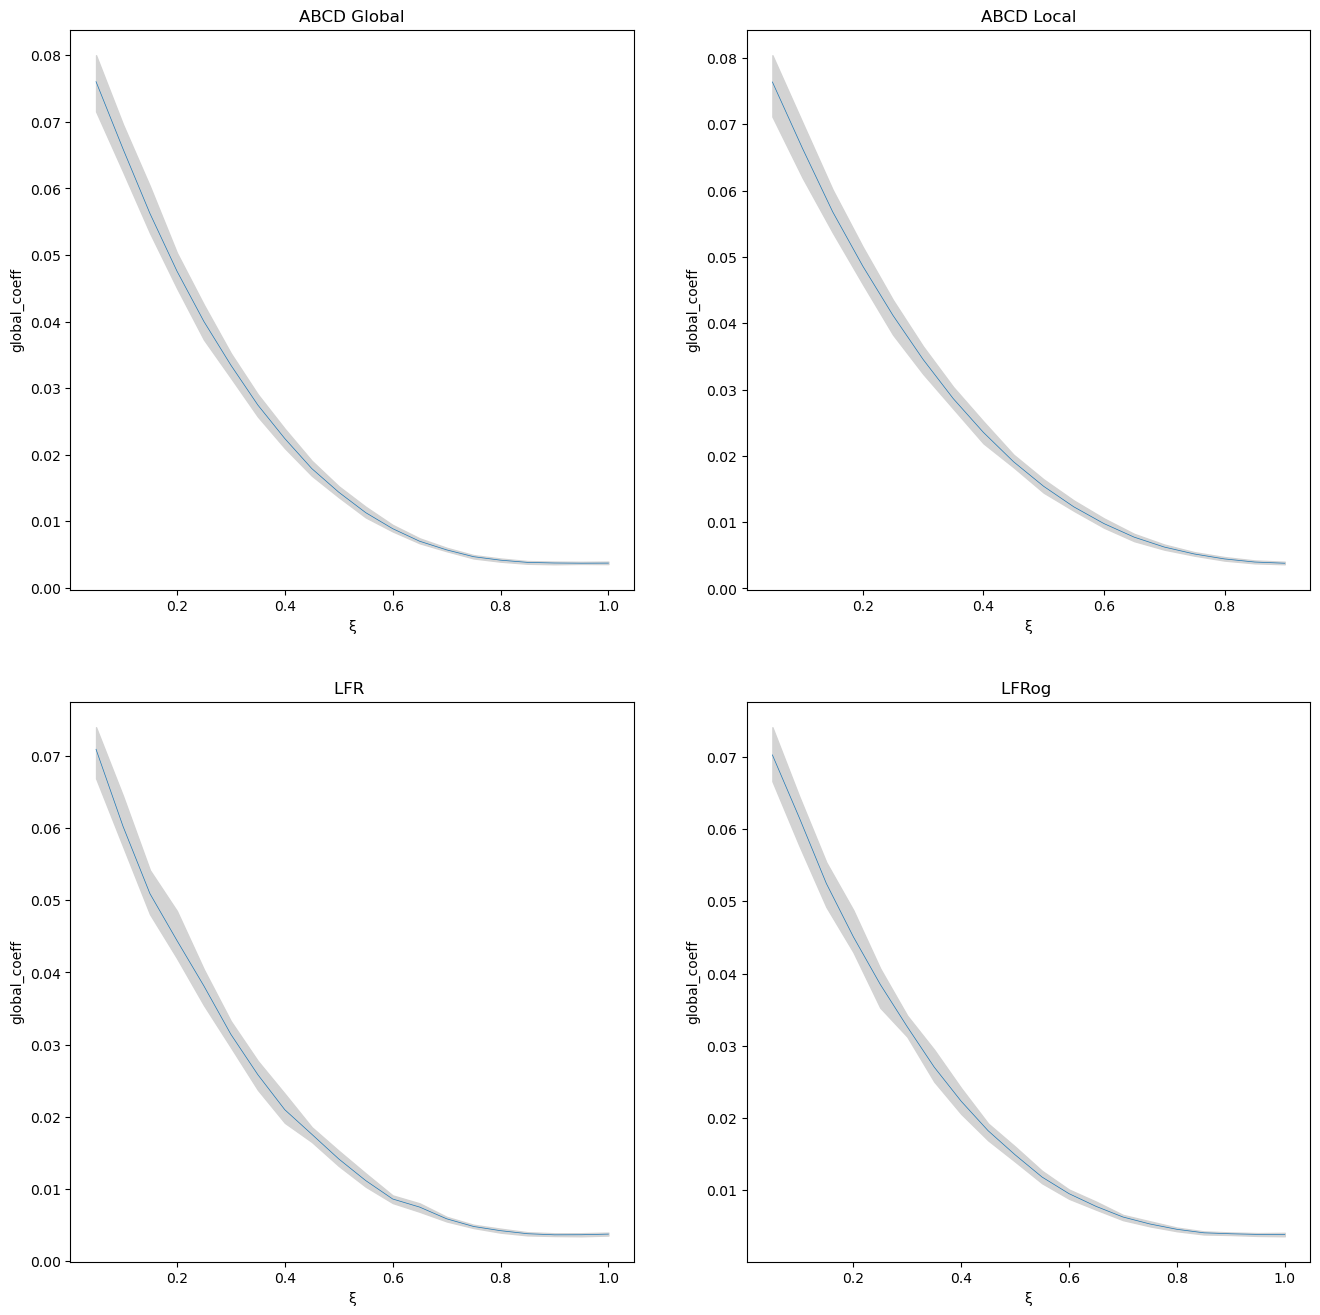

In [55]:
fig = figure("$(attr) ξ plot", figsize = (16,16))
k = 1
for (algo, islocal) in [("ABCD", false),("ABCD", true),("LFR", ""),("LFRog", "")]
    (typeof(islocal) == Bool) ? (islocal ? algtype = "Local" : algtype = "Global") : algtype = ""
    subplot(parse(Int, "22" * "$k"))
    vals = zeros(length(ξs),3)
    for (i, xi) in enumerate(ξs)
        ξs == 0 && continue
        try
            data = get_plot_data(algo, islocal, attr, ξ = xi)
            vals[i,:] = [mean(data), quantile(data, α/2), 
                        quantile(data,1 - α/2)]
        catch
            vals[i,:] = [NaN,NaN,NaN]
        end
    end
    plot(ξs[2:end],vals[2:end,1], linewidth=0.5)
    fill_between(ξs[2:end],vals[2:end,2],vals[2:end,3], color = "lightgray")
    xlabel("ξ")
    ylabel("$(attr)")
    PyPlot.title("$(algo) $algtype") 
    k += 1
end

#saving to a file:
#savefig("$(attr)_xi_separate_plots.eps")

### Joint Plots

In [56]:
#Parameters:

ξ = 0.5
β = 1.5
γ = 2.5
min_deg = 5
attr = :modularity
α = 0.05
ribbon = false #true if ribbon - in the most cases it is unreadable

false

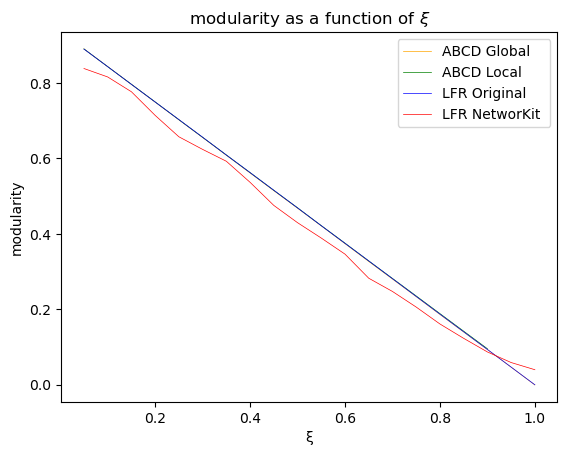

PyObject Text(0.5, 1.0, 'modularity as a function of $ξ$')

In [57]:
for (algo, islocal, color) in [("ABCD", false, "orange"),("ABCD", true, "green"),
        ("LFRog", "", "blue"), ("LFR", "", "red")]
    (typeof(islocal) == Bool) ? (islocal ? algtype = "Local" : algtype = "Global") : algtype = ""
    vals = zeros(length(ξs),3)
    for (i, xi) in enumerate(ξs)
        ξs == 0 && continue
        try
            data = get_plot_data(algo, islocal, attr, ξ = xi)
            vals[i,:] = [mean(data), quantile(data, α/2), 
                        quantile(data,1 - α/2)]
        catch
            vals[i,:] = [NaN,NaN,NaN]
        end
    end
    algo == "LFRog" ? algo = "LFR Original" : (algo == "LFR" && (algo = "LFR NetworKit"))
    plot(ξs[2:end],vals[2:end,1], linewidth=0.5, label = "$algo $algtype",  c = color)
    ribbon && fill_between(ξs[2:end],vals[2:end,2],vals[2:end,3], alpha = 0.1)
    xlabel("ξ")
    ylabel("$(attr)")
     
end
legend(loc = "upper right")
PyPlot.title(L"%$attr as a function of $ξ$")

#saving to a file:
#savefig("$(attr)_xi_plots.eps")

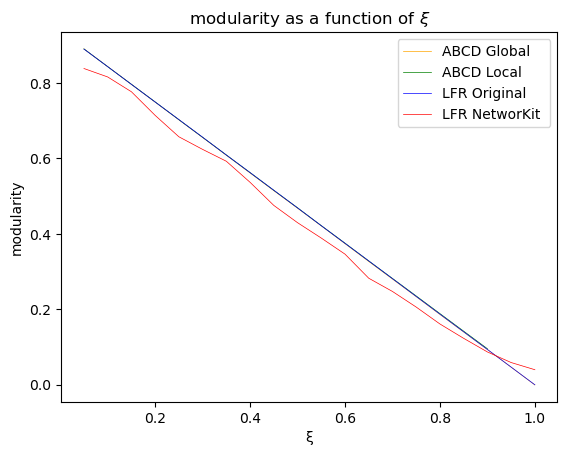

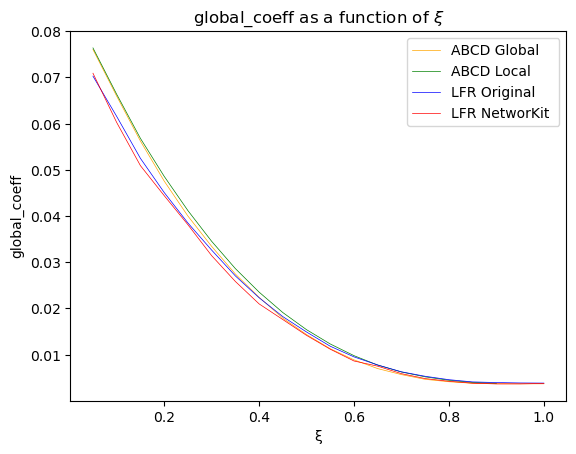

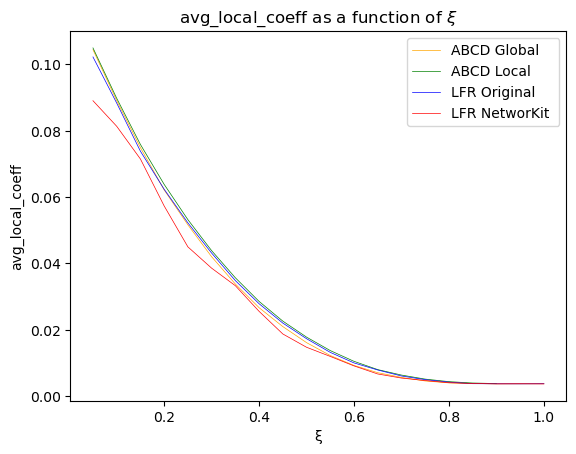

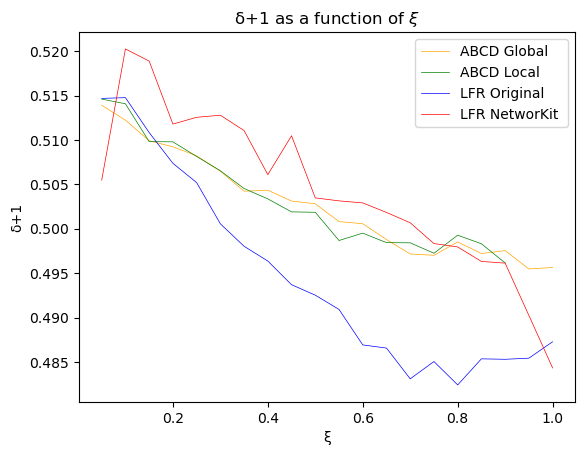

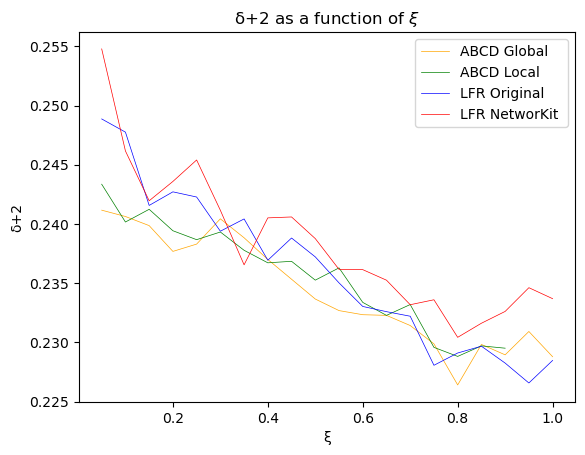

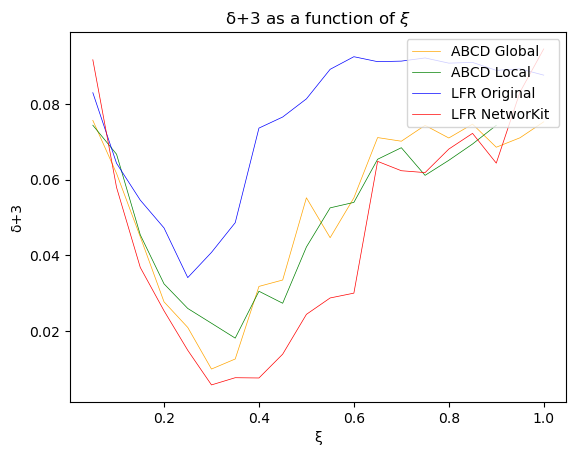

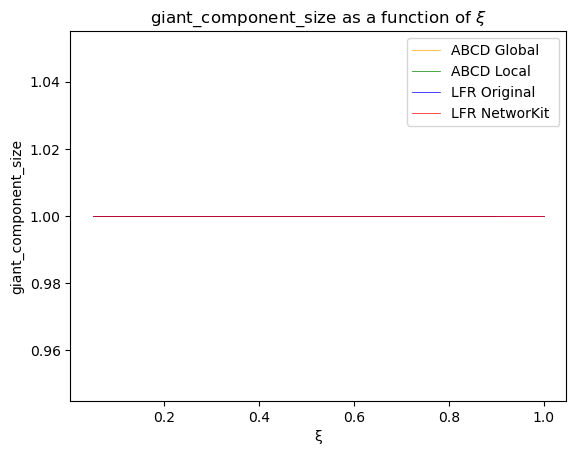

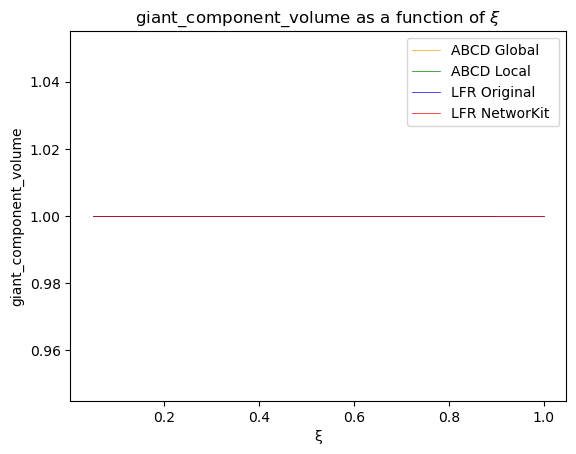

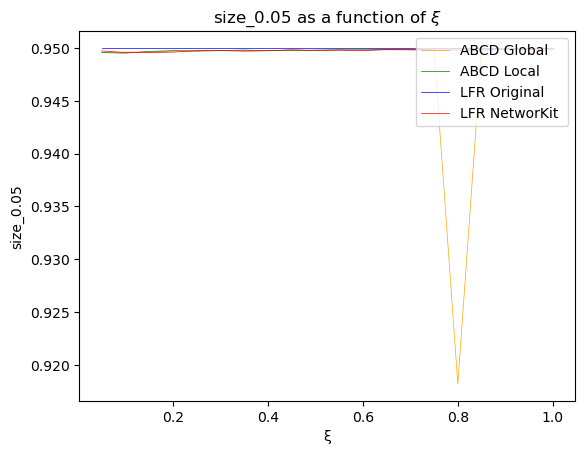

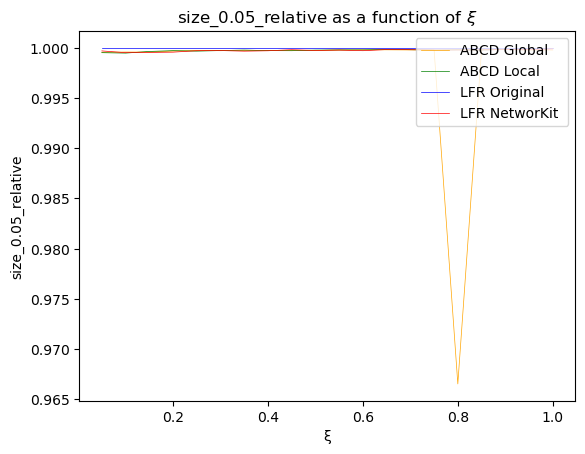

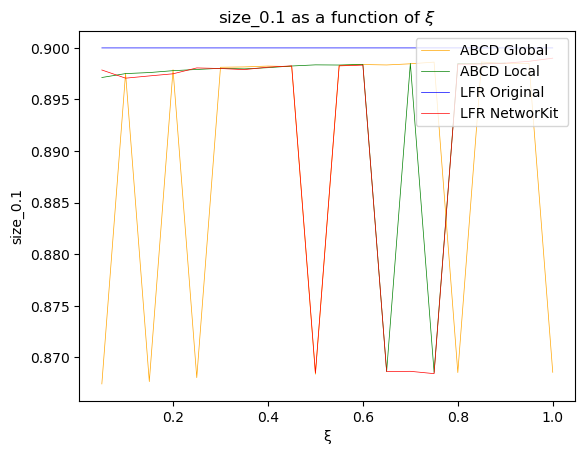

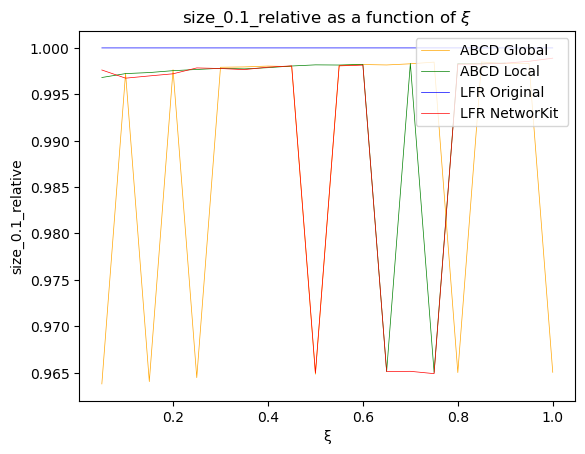

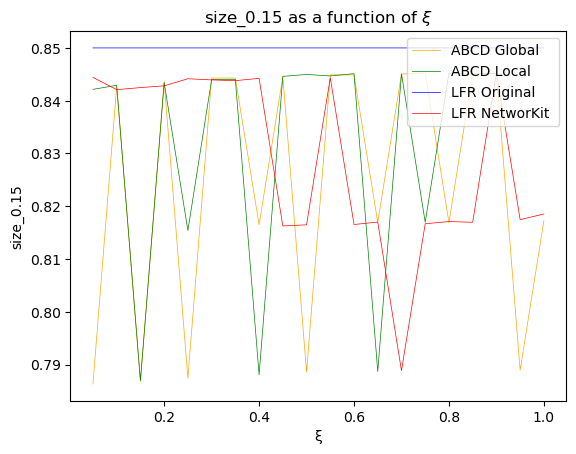

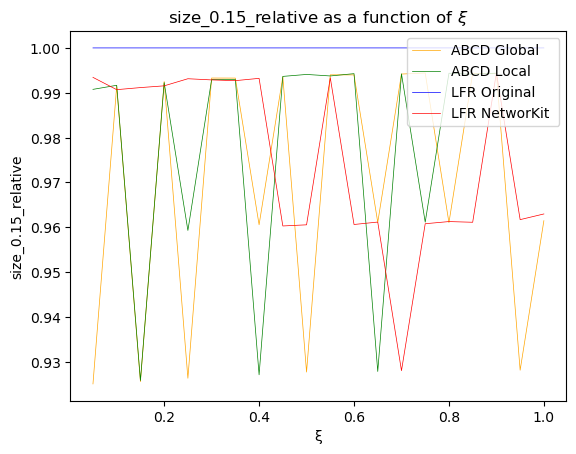

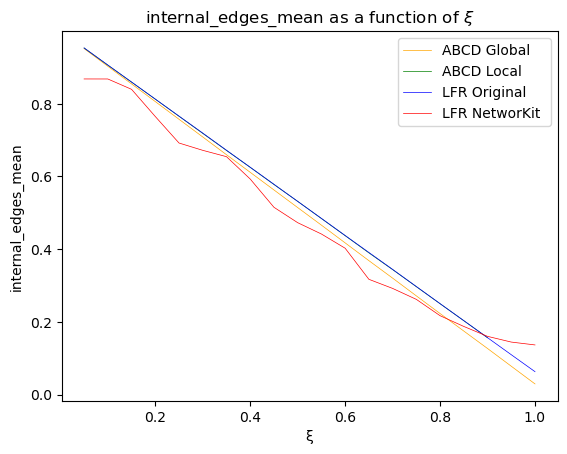

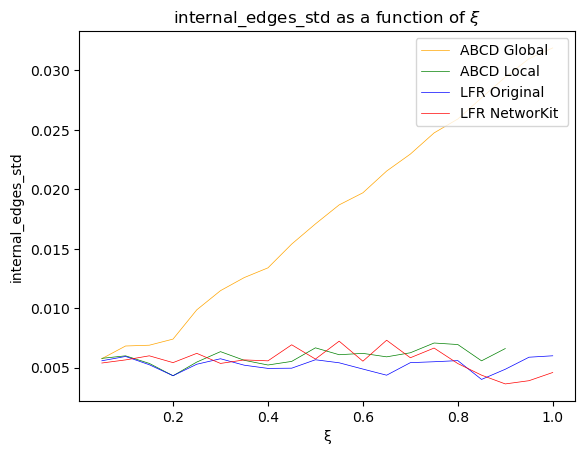

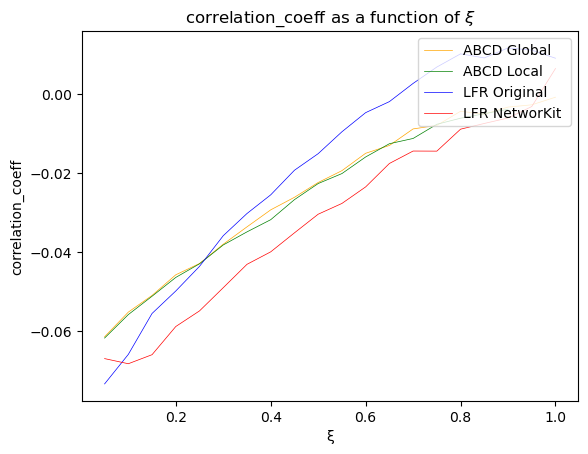

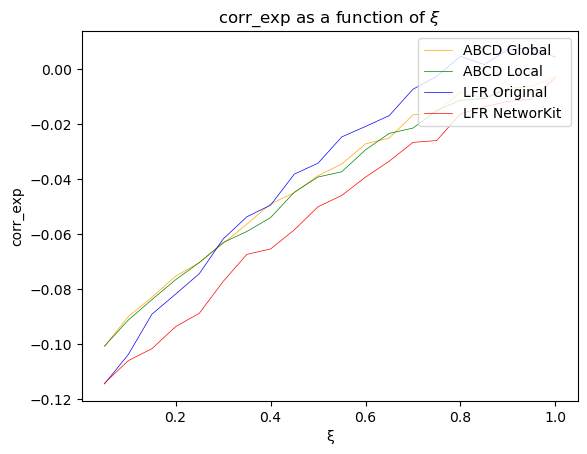

In [58]:
for attr in colnames[2:end]
    fig = figure()
    for (algo, islocal, color) in [("ABCD", false, "orange"),("ABCD", true, "green"),
        ("LFRog", "", "blue"), ("LFR", "", "red")]
        (typeof(islocal) == Bool) ? (islocal ? algtype = "Local" : algtype = "Global") : algtype = ""
        vals = zeros(length(ξs),3)
        for (i, xi) in enumerate(ξs)
            ξs == 0 && continue
            try
                data = get_plot_data(algo, islocal, attr, ξ = xi)
                vals[i,:] = [mean(data), quantile(data, α/2), 
                        quantile(data,1 - α/2)]
            catch
                vals[i,:] = [NaN,NaN,NaN]
            end
        end
        algo == "LFRog" ? algo = "LFR Original" : (algo == "LFR" && (algo = "LFR NetworKit"))
        plot(ξs[2:end],vals[2:end,1], linewidth=0.5, label = "$algo $algtype",  c = color)
        ribbon && fill_between(ξs[2:end],vals[2:end,2],vals[2:end,3], alpha = 0.1)
        xlabel("ξ")
        ylabel("$(attr)")
     
    end
    legend(loc = "upper right")
    PyPlot.title(L"%$attr as a function of $ξ$")
end